**Este notebook muestra el proceso de clusterizar los archivos simples de coches (ya filtrados y limpiados) desde su visualización básica hasta la realización del bounding box de cada elemento**

1. Visualización de puntos
2. Clustering
3. Bounding boxes
---

In [6]:
import pyvista as pv
import numpy as np
import pandas as pd
from pyvista import set_jupyter_backend
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [7]:
csv = pd.read_csv('C_coche_coche_moto_clusters.csv')
data_frame = pd.DataFrame(csv)

X = data_frame['x']
Y = data_frame['y']
Z = data_frame['z']

## **(FORMA DE QUITAR EL SUELO)**

In [21]:
"""
m = 0.06  # Pendiente
n = 5.8   # Intersección con el eje Y

# tolerancia para los puntos cercanos a la recta
tolerancia = 0.3 
# valor esperado de y para cada x según la ecuación de la recta
y_esperado = m * data_frame['x'] + n

data_frame = data_frame[np.abs(data_frame['y'] - y_esperado) > tolerancia]

X = data_frame['x']
Y = data_frame['y']
Z = data_frame['z']
"""

## **MOSTRAR VEHÍCULOS**

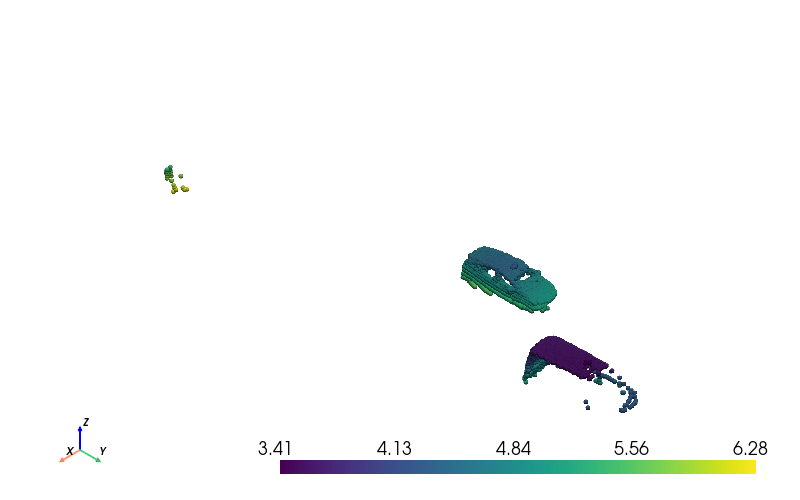

In [8]:
set_jupyter_backend('static')
points = np.column_stack((Z, -X, -Y)) # combinación buena

# Nube de puntos en PyVista
cloud = pv.PolyData(points)
plotter = pv.Plotter(window_size=[800, 500])

plotter.add_mesh(cloud, render_points_as_spheres=True, point_size=5, cmap='viridis', scalars=Y)

plotter.show_axes()
plotter.camera.zoom(1.3)

plotter.show()

## **CLUSTERING**

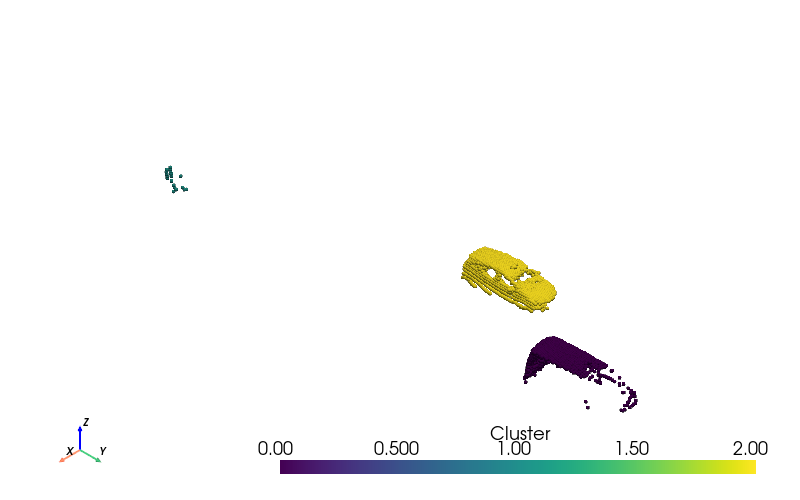

In [9]:
points = np.column_stack((Z, -X, -Y))

# Normalizar datos
scaler = StandardScaler()
points_scaled = scaler.fit_transform(points)

db = DBSCAN(eps=0.7, min_samples=5).fit(points_scaled)
labels = db.labels_

cloud = pv.PolyData(points)
cloud.point_data['Cluster'] = labels

plotter = pv.Plotter(window_size=[800, 500])
plotter.add_mesh(cloud, render_points_as_spheres=True, point_size=4, scalars='Cluster', cmap='viridis')

plotter.show_axes()
plotter.camera.zoom(1.3)

plotter.show()

## **BOUNDING BOX**

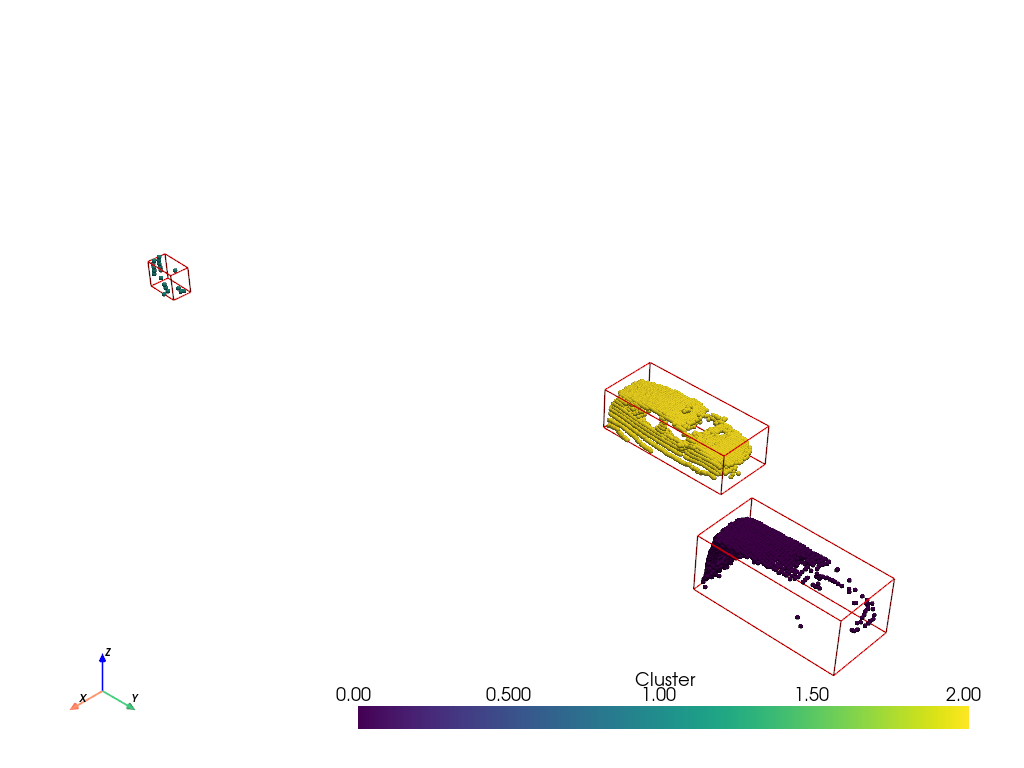

In [10]:
points = np.column_stack((Z, -X, -Y))
scaler = StandardScaler()
points_scaled = scaler.fit_transform(points)

db = DBSCAN(eps=0.7, min_samples=5).fit(points_scaled)
labels = db.labels_

plotter = pv.Plotter()
cloud = pv.PolyData(points)
cloud.point_data['Cluster'] = labels
plotter.add_mesh(cloud, render_points_as_spheres=True, point_size=5, scalars='Cluster')

bounding_boxes = []

# Iterar sobre cada cluster identificado
for label in np.unique(labels):
    if label == -1:  # -1 es ruido
        continue
    
    cluster_points = points[labels == label]
    
    min_x, min_y, min_z = np.min(cluster_points, axis=0)
    max_x, max_y, max_z = np.max(cluster_points, axis=0)
    
    bounding_boxes.append((min_x, max_x, min_y, max_y, min_z, max_z))

for bbox in bounding_boxes:
    min_x, max_x, min_y, max_y, min_z, max_z = bbox
    box = pv.Cube(bounds=(min_x, max_x, min_y, max_y, min_z, max_z))
    plotter.add_mesh(box, color='red', style='wireframe', line_width=1.5)

plotter.show_axes()
plotter.camera.zoom(1.3)

plotter.show()